In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import string

from string import digits
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
%%time
data = pd.read_csv('../out_files/tell_all_corrected.csv', nrows=200000)

CPU times: user 4.72 s, sys: 504 ms, total: 5.22 s
Wall time: 8.67 s


In [3]:
len(data)

200000

In [4]:
data = data.drop(data[data.political_party == 'αντιπολιτευση'].index) #remove rows from αντιπολιτευση or βουλη
data = data.drop(data[data.political_party == 'βουλη'].index)

In [5]:
len(data)

193448

In [6]:
data['sitting_date'] = pd.to_datetime(data['sitting_date'])
data['year'] = data['sitting_date'].apply(lambda x: x.year)
data.head(3)

member_name sitting_date parliamentary_period  \
0  κρητικος νικολαου παναγιωτης   1989-03-07             period 5   
1  κρητικος νικολαου παναγιωτης   1989-03-07             period 5   
2  κρητικος νικολαου παναγιωτης   1989-03-07             period 5   

  parliamentary_session parliamentary_sitting                 political_party  \
0             session 1             sitting 1  πανελληνιο σοσιαλιστικο κινημα   
1             session 1             sitting 1  πανελληνιο σοσιαλιστικο κινημα   
2             session 1             sitting 1  πανελληνιο σοσιαλιστικο κινημα   

                                     government member_region  \
0  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']   β' πειραιως   
1  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']   β' πειραιως   
2  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']   β' πειραιως   

                                              roles member_gender  \
0  ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']          male   
1  ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']          male   
2  ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']          male   

  speaker_info                                             speech  year  
0   προεδρευων   Παρακαλείται ο Γραμματέας κ. Βουλγαράκης να σ...  1989  
1   προεδρευων   Παρακαλείται ο κύριος Γραμματέας να συνοδεύσε...  1989  
2   προεδρευων   Κύριοι συνάδελφοι, παρακαλώ τη Βουλή να εξουσ...  1989

In [7]:
with open ('../out_files/greek_stopwords_cschwem2er_with_accents.txt', 'r') as f:
    stopwords1 = f.read().upper().split(',')#.translate(str.maketrans('άέόώήίϊΐύϋΰ', 'αεοωηιιιυυυ'))
with open ('../out_files/greek_stopwords_spacy_accents.txt', 'r') as f:
    stopwords2 = f.read().upper().split(',')
stopwords = stopwords1 + stopwords2 # merge two files

In [8]:
remove_digits = str.maketrans('', '', digits)
grouped_data = data.groupby(['political_party','year'])['speech'].apply(''.join).reset_index()
grouped_data['speech'] = grouped_data['speech'].apply(lambda x: x.translate(remove_digits))

grouped_data['speech'] = grouped_data['speech'].str.upper()
grouped_data['speech'] = grouped_data['speech'].str.translate(str.maketrans('', '', string.punctuation))

remove = ('|'.join(stopwords)).upper()

grouped_data['speech'] = grouped_data['speech'].replace(r'\b('+remove+r')\b', '', regex=True)
grouped_data['speech'] = grouped_data['speech'].str.lower()
grouped_data.speech = grouped_data.speech.replace('\s+', ' ', regex=True)

In [9]:
max(grouped_data.year)

1994

In [10]:
grouped_data

political_party  year  \
0                        ανεξαρτητοι (εκτος κομματος)  1990   
1                        ανεξαρτητοι (εκτος κομματος)  1991   
2                        ανεξαρτητοι (εκτος κομματος)  1992   
3                        ανεξαρτητοι (εκτος κομματος)  1993   
4                                δημοκρατικη ανανεωση  1989   
5                                δημοκρατικη ανανεωση  1990   
6                                 εξωκοινοβουλευτικός  1989   
7                                 εξωκοινοβουλευτικός  1990   
8                                 εξωκοινοβουλευτικός  1991   
9                                 εξωκοινοβουλευτικός  1992   
10                                εξωκοινοβουλευτικός  1993   
11                                εξωκοινοβουλευτικός  1994   
12                        κομμουνιστικο κομμα ελλαδας  1991   
13                        κομμουνιστικο κομμα ελλαδας  1992   
14                        κομμουνιστικο κομμα ελλαδας  1993   
15                        κομμουνιστικο κομμα ελλαδας  1994   
16                        λαικος ορθοδοξος συναγερμος  1989   
17                        λαικος ορθοδοξος συναγερμος  1990   
18                        λαικος ορθοδοξος συναγερμος  1991   
19                        λαικος ορθοδοξος συναγερμος  1992   
20                        λαικος ορθοδοξος συναγερμος  1993   
21                                     νεα δημοκρατια  1989   
22                                     νεα δημοκρατια  1990   
23                                     νεα δημοκρατια  1991   
24                                     νεα δημοκρατια  1992   
25                                     νεα δημοκρατια  1993   
26                                     νεα δημοκρατια  1994   
27  οικολογοι εναλλακτικοι (ομοσπονδια οικολογικων...  1989   
28  οικολογοι εναλλακτικοι (ομοσπονδια οικολογικων...  1990   
29  οικολογοι εναλλακτικοι (ομοσπονδια οικολογικων...  1991   
30  οικολογοι εναλλακτικοι (ομοσπονδια οικολογικων...  1992   
31  οικολογοι εναλλακτικοι (ομοσπονδια οικολογικων...  1993   
32                     πανελληνιο σοσιαλιστικο κινημα  1989   
33                     πανελληνιο σοσιαλιστικο κινημα  1990   
34                     πανελληνιο σοσιαλιστικο κινημα  1991   
35                     πανελληνιο σοσιαλιστικο κινημα  1992   
36                     πανελληνιο σοσιαλιστικο κινημα  1993   
37                     πανελληνιο σοσιαλιστικο κινημα  1994   
38                                    πολιτικη ανοιξη  1993   
39                                    πολιτικη ανοιξη  1994   
40  συνασπισμος της αριστερας των κινηματων και τη...  1989   
41  συνασπισμος της αριστερας των κινηματων και τη...  1990   
42  συνασπισμος της αριστερας των κινηματων και τη...  1991   
43  συνασπισμος της αριστερας των κινηματων και τη...  1992   
44  συνασπισμος της αριστερας των κινηματων και τη...  1993   

                                               speech  
0    κύριε πρόεδρε κυρίες κύριοι συνάδελφοι θεωρώ ...  
1    κύριε πρόεδρε συζητηθεί λεπτά κύριε πρόεδρε κ...  
2    κύριε πρόεδρε παρακαλώ λόγο κύριε πρόεδρε παρ...  
3    συνηγορούμε κύριε πρόεδρε εθνική παραλιακή οδ...  
4    σημαντικό αξιότιμες κυρίες αξιότιμοι κύριοι σ...  
5    επαναφορά ενισχυμένης αναλογικής συνέπεια εντ...  
6    κυρίες κύριοι βουλευτές συζήτηση προγραμματικ...  
7    κύριε πρόεδρε κυρίες κύριοι βουλευτές αισθάνο...  
8    κύριε πρόεδρε θέμα προεδρείου κ κουλούρη δικα...  
9    κύριε πρόεδρε κύριε πρόεδρε ζητήσω άδεια προε...  
10   κύριε πρόεδρε κύριοι βουλευτές αποκρατικοποίη...  
11   λύση προμήθειας νερού πλευράς ευδαπ λύση σκεφ...  
12   κύριε πρόεδρε κύριοι βουλευτές παρόν νομοσχέδ...  
13   κρατείται κρατείταικύριε πρόεδρε πω αρχήν υπά...  
14  κύριοι συνάδελφοι έκτη ή έβδομη φορά κάνω λάθο...  
15   κύριε πρόεδρε δημοπρασία μικρό νησί ηράκλειο ...  
16   βουλή εγκρίνει κύριοι συνάδελφοι εισερχόμαστε...  
17   κύριοι συνάδελφοι τιμή ανακοινώσω σώμα μέρους...  
18   κ ακριτίδης λόγο συζητούμε τροπολογίες άρθρα ...  
19   κύριοι συνάδελ

In [14]:
def calculate_similarities(example_speech):
    vec = TfidfVectorizer(min_df=0.1, max_df=0.9, lowercase=False) # (dina) added lowercase=False)
    X = vec.fit_transform(example_speech)
    return cosine_similarity(X)

In [15]:
def find_all_similarities(grouped_data, party1, party2):
    similarities = []
    for i in range(1989, 1995):
        example = grouped_data[(grouped_data.year == i)]
        example = example.set_index('political_party')
        if (party1 in example.index) and (party2 in example.index):
            similarity = calculate_similarities(example.speech)[example.index.get_loc(party1)]\
                [example.index.get_loc(party2)]
            similarities.append(similarity)
        else:
            break
    return similarities

In [16]:
similarities = find_all_similarities(grouped_data, 'νεα δημοκρατια', 'πανελληνιο σοσιαλιστικο κινημα')
similarities

[0.9000407222380631,
 0.8831824021767,
 0.8606490566584081,
 0.8312799458461035,
 0.9254285181451666,
 0.5668556579585282]

In [17]:
for_plot = pd.DataFrame()
for_plot['year'] = range(1989, 1995)
for_plot['pasok-nd'] = similarities
for_plot = for_plot.set_index('year')
for_plot

pasok-nd
year          
1989  0.900041
1990  0.883182
1991  0.860649
1992  0.831280
1993  0.925429
1994  0.566856

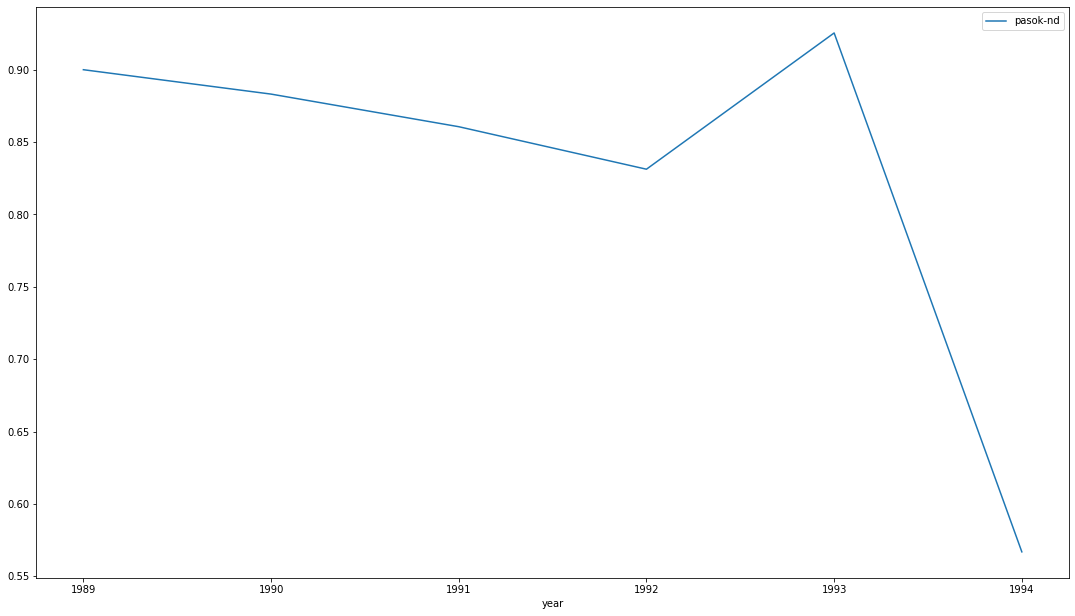

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

for_plot.plot(x_compat=True,ax=ax)

ax.locator_params(integer=True)
#ax.xaxis.set_tick_params(reset=True)

plt.show()

### Stemming

In [19]:
grouped_data_stemmed = grouped_data.copy()
grouped_data_stemmed['speech'] = grouped_data_stemmed.speech.str.translate(
                 str.maketrans('άέόώήίϊΐύϋΰ', 'αεοωηιιιυυυ'))
grouped_data_stemmed['speech'] = grouped_data_stemmed['speech'].str.upper()
grouped_data_stemmed.head(3)

political_party  year  \
0  ανεξαρτητοι (εκτος κομματος)  1990   
1  ανεξαρτητοι (εκτος κομματος)  1991   
2  ανεξαρτητοι (εκτος κομματος)  1992   

                                              speech  
0   ΚΥΡΙΕ ΠΡΟΕΔΡΕ ΚΥΡΙΕΣ ΚΥΡΙΟΙ ΣΥΝΑΔΕΛΦΟΙ ΘΕΩΡΩ ...  
1   ΚΥΡΙΕ ΠΡΟΕΔΡΕ ΣΥΖΗΤΗΘΕΙ ΛΕΠΤΑ ΚΥΡΙΕ ΠΡΟΕΔΡΕ Κ...  
2   ΚΥΡΙΕ ΠΡΟΕΔΡΕ ΠΑΡΑΚΑΛΩ ΛΟΓΟ ΚΥΡΙΕ ΠΡΟΕΔΡΕ ΠΑΡ...

In [20]:
import nltk
from nltk.tokenize import word_tokenize
from greek_stemmer import GreekStemmer

stemmer = GreekStemmer()
def stemming_tokenizer(str_input):
#     words = str_input.split() # (dina) replace split with tokenize for better tokenization
    words = nltk.word_tokenize(str_input)
    #words = [stemmer.stem(word) for word in words] # (dina) better avoid assigning to a list itself while changing it
    stemmed_words = [stemmer.stem(word) for word in words] # dina) changed words to stemmed_words: avoid assigning to a list itsself while changing it
    print(stemmed_words[:10])
    return stemmed_words

In [21]:
def calculate_similarities_stemming(example_speech):
    vec = TfidfVectorizer(min_df=0.1, max_df=0.9, tokenizer = stemming_tokenizer, lowercase=False) # (dina) added lowercase=False)
    X = vec.fit_transform(example_speech)
    return cosine_similarity(X)

In [24]:
def find_all_similarities_stemming(grouped_data_stemmed, party1, party2):
    similarities = []
    for i in range(1989, 1995):
        example = grouped_data_stemmed[(grouped_data_stemmed.year == i)]
        example = example.set_index('political_party')
        if (party1 in example.index) and (party2 in example.index):
            similarity = calculate_similarities_stemming(example.speech)[example.index.get_loc(party1)]\
                [example.index.get_loc(party2)]
            similarities.append(similarity)
        else:
            break
    return similarities

In [25]:
similarities = find_all_similarities_stemming(grouped_data_stemmed, 'νεα δημοκρατια', 'πανελληνιο σοσιαλιστικο κινημα')
similarities

['ΣΗΜΑΝΤΙΚ', 'ΑΞΙΟΤΙΜ', 'ΚΥΡΙ', 'ΑΞΙΟΤΙΜ', 'ΚΥΡΙ', 'ΣΥΝΑΔΕΛΦ', 'Σ', 'ΠΕΡΙΟΔ', 'ΒΟΥΛΕΥΤ', 'ΕΠΗΛΘ']
['ΚΥΡΙ', 'ΚΥΡΙ', 'ΒΟΥΛΕΥΤ', 'ΣΥΖΗΤΗΣ', 'ΠΡΟΓΡΑΜΜΑΤ', 'ΔΗΛΩΣ', 'ΒΟΥΛ', 'ΧΩΡ', 'ΖΩ', 'ΕΠΑΝΑΛΑΜΒΑΝ']
['ΒΟΥΛ', 'ΕΓΚΡΙΝ', 'ΚΥΡΙ', 'ΣΥΝΑΔΕΛΦ', 'ΕΙΣΕΡΧ', 'ΗΜΕΡΗΣ', 'ΔΙΑΤΑΞΗΤ', 'ΝΟΜΟΘΕΤ', 'ΕΡΓΑΣ', 'ΣΥΖΗΤ']
['ΚΥΡΙ', 'ΚΥΡΙ', 'ΣΥΝΑΔΕΛΦ', 'ΑΝΑΛΑΜΒΑΝ', 'ΠΡΟΕΔΡ', 'ΣΩΜ', 'ΑΡΧΗΝ', 'ΕΥΧΑΡΙΣΤ', 'ΨΗΦΙΣ', 'ΕΥΧΑΡΙΣΤ']
['ΕΥΧΑΡΙΣΤ', 'ΗΡΘ', 'ΣΕΙΡ', 'ΑΝΤΙΠΡΟΣΩΠ', 'ΕΛΛΗΝΙΔ', 'ΕΛΛΗΝ', 'ΠΟΛΙΤ', 'ΚΑΤΑΚΤΗΣ', 'ΟΙΚΟΛΟΓ', 'ΚΙΝΗΜ']
['ΠΑΡΑΚΑΛΕΙΤΑ', 'ΓΡΑΜΜΑΤ', 'Κ', 'ΒΟΥΛΓΑΡΑΚ', 'ΣΥΝΟΔΕΥΣ', 'ΜΑΚΑΡΙ', 'ΑΡΧΙΕΠΙΣΚΟΠ', 'ΑΘΗΝ', 'ΠΑΣ', 'ΕΛΛΑΔ']
['ΚΥΡΙ', 'ΠΡΟΕΔΡ', 'ΣΥΝΗΓΟΡ', 'ΑΙΤΗΜ', 'ΣΥΖΗΤΗΣ', 'ΑΡΧΙΣ', 'ΠΑΡΑΣΚΕΥ', 'ΠΡΩ', 'ΑΝΑΓΚ', 'ΑΝΕΣ']
['ΚΥΡΙ', 'ΠΡΟΕΔΡ', 'ΚΥΡΙ', 'ΚΥΡΙ', 'ΣΥΝΑΔΕΛΦ', 'ΘΕΩΡ', 'ΙΔΙΑΙΤΕΡ', 'ΤΙΜ', 'ΕΥΚΑΙΡ', 'ΔΟΘΗΚ']
['ΕΠΑΝΑΦΟΡ', 'ΕΝΙΣΧΥΜΕΝ', 'ΑΝΑΛΟΓ', 'ΣΥΝΕΠΕΙ', 'ΕΝΤΑΘ', 'ΔΙΧΑΣΤ', 'ΤΑΣ', 'ΕΠΙΣΤΡΕΨΟΜ', 'ΜΟΡΦ', 'ΔΙΑΚΥΒΕΡΝΗΣ']
['ΚΥΡΙ', 'ΠΡΟΕΔΡ', 'ΚΥΡΙ', 'ΚΥΡΙ', 'ΒΟΥΛΕΥΤ', 'ΑΙΣΘΑΝ', 'ΠΡΑΓΜΑΤ', 'ΜΕΓΑΛ', 'ΤΙΜ', 'ΒΡΙΣΚ']
['ΚΥ

[0.9436698957153643,
 0.934029292632601,
 0.9463150717421333,
 0.8869578576461316,
 0.9636528034690464,
 0.7611547590726812]

In [26]:
for_plot = pd.DataFrame()
for_plot['year'] = range(1989, 1995)
for_plot['pasok-nd'] = similarities
for_plot = for_plot.set_index('year')
for_plot

pasok-nd
year          
1989  0.943670
1990  0.934029
1991  0.946315
1992  0.886958
1993  0.963653
1994  0.761155

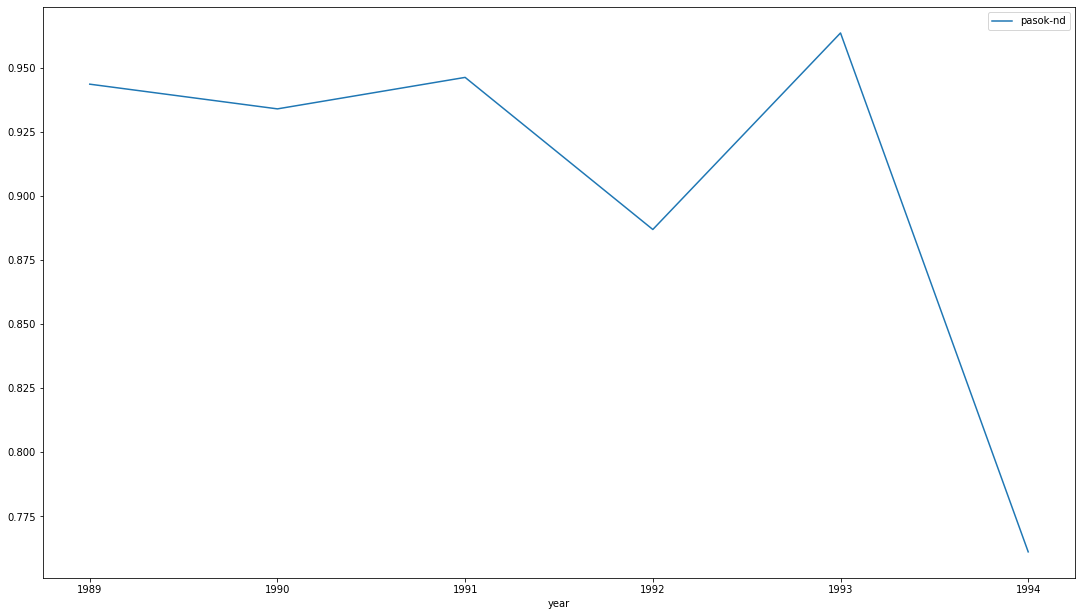

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

for_plot.plot(x_compat=True,ax=ax)

ax.locator_params(integer=True)
#ax.xaxis.set_tick_params(reset=True)

plt.show()

### Lemmatization

In [28]:
grouped_data_lemmatized = grouped_data.copy()
grouped_data_lemmatized.head(3)

political_party  year  \
0  ανεξαρτητοι (εκτος κομματος)  1990   
1  ανεξαρτητοι (εκτος κομματος)  1991   
2  ανεξαρτητοι (εκτος κομματος)  1992   

                                              speech  
0   κύριε πρόεδρε κυρίες κύριοι συνάδελφοι θεωρώ ...  
1   κύριε πρόεδρε συζητηθεί λεπτά κύριε πρόεδρε κ...  
2   κύριε πρόεδρε παρακαλώ λόγο κύριε πρόεδρε παρ...

In [29]:
from cltk.stem.lemma import LemmaReplacer
from cltk.corpus.utils.formatter import cltk_normalize

lemmatizer = LemmaReplacer('greek')
def lemmatizing_tokenizer(str_input):
    speeches = cltk_normalize(str_input)
    lemmas = lemmatizer.lemmatize(speeches)
    print(lemmas[:10])
    return lemmas

In [30]:
def calculate_similarities_lemmatizing(example_speech):
    vec = TfidfVectorizer(min_df=0.1, max_df=0.9, tokenizer = lemmatizing_tokenizer, lowercase=False) # (dina) added lowercase=False)
    X = vec.fit_transform(example_speech)
    return cosine_similarity(X)

In [31]:
def find_all_similarities_lemmatizing(grouped_data_lemmatized, party1, party2):
    similarities = []
    for i in range(1989, 1995):
        example = grouped_data_lemmatized[(grouped_data_lemmatized.year == i)]
        example = example.set_index('political_party')
        if (party1 in example.index) and (party2 in example.index):
            similarity = calculate_similarities_lemmatizing(example.speech)[example.index.get_loc(party1)]\
                [example.index.get_loc(party2)]
            similarities.append(similarity)
        else:
            break
    return similarities

In [32]:
similarities = find_all_similarities_lemmatizing(grouped_data_lemmatized, 'νεα δημοκρατια', 'πανελληνιο σοσιαλιστικο κινημα')
similarities

['σημαντικό', 'αξιότιμες', 'κυρίες', 'αξιότιμοι', 'κύριος', 'συνάδελφοι', 'σ', 'περίοδο', 'βουλευτικός', 'επήλθε']
['κυρίες', 'κύριος', 'βουλευτές', 'συζήτηση', 'προγραμματικές', 'δηλόω', 'βουλή', 'χῶρος', 'ζωής', 'επαναλαμβάνεται']
['βουλή', 'εγκρίνει', 'κύριος', 'συνάδελφοι', 'εισερχόμαστε', 'ημερήσια', 'διάταξητης', 'νομοθετικης', 'εργασιας', 'συζητηθεί']
['κυρίες', 'κύριος', 'συνάδελφοι', 'αναλαμβάνοντας', 'προεδρία', 'σῶμα', 'αρχήν', 'ευχαριστήσω', 'ψήφισαν', 'ευχαριστήσω']
['ευχαριστώ', 'ήρθε', 'σειρά', 'αντιπρόσωποι', 'ελληνίδων', 'ελλήνων', 'πολιτών', 'κατάκτηση', 'οικολογικό', 'κίνημα']
['παρακαλείται', 'γραμματεύς', 'κ', 'βουλγαράκης', 'συνοδεύω', 'μακαριότατο', 'αρχιεπίσκοπο', 'αθηνών', 'πᾶς', 'ελλάδος']
['κύριος', 'πρόεδρος', 'συνηγορήσουμε', 'αίτημα', 'συζήτηση', 'αρχίσει', 'παρασκευή', 'πρωί', 'ανάγκη', 'άνεση']
['κύριος', 'πρόεδρος', 'κυρίες', 'κύριος', 'συνάδελφοι', 'θεωρώ', 'ιδιαίτερη', 'τιμή', 'ευκαιρία', 'δόθηκε']
['επαναφορά', 'ενισχυμένης', 'αναλογικής', 'συνέπε

[0.9219899693903789,
 0.9018187061736135,
 0.8905283386491766,
 0.8405513181552755,
 0.939672226855074,
 0.572350418512979]

In [33]:
for_plot = pd.DataFrame()
for_plot['year'] = range(1989, 1995)
for_plot['pasok-nd'] = similarities
for_plot = for_plot.set_index('year')
for_plot

pasok-nd
year          
1989  0.921990
1990  0.901819
1991  0.890528
1992  0.840551
1993  0.939672
1994  0.572350

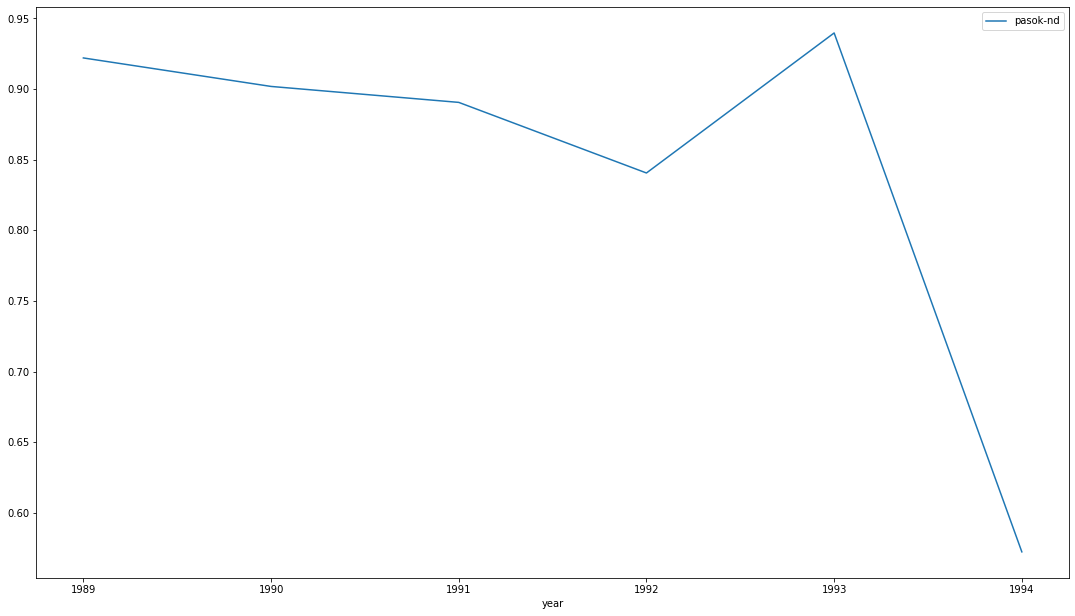

In [34]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

for_plot.plot(x_compat=True,ax=ax)

ax.locator_params(integer=True)
#ax.xaxis.set_tick_params(reset=True)

plt.show()

### Spacy Lemmatization

In [35]:
spacy_data = pd.read_csv('../out_files/tell_all_corrected.csv', nrows=15000)

spacy_data['sitting_date'] = pd.to_datetime(spacy_data['sitting_date'])
spacy_data['year'] = spacy_data['sitting_date'].apply(lambda x: x.year)

remove_digits = str.maketrans('', '', digits)
spacy_data = spacy_data.groupby(['political_party','year'])['speech'].apply(''.join).reset_index()
spacy_data['speech'] = spacy_data['speech'].apply(lambda x: x.translate(remove_digits))

spacy_data['speech'] = spacy_data['speech'].str.upper()
spacy_data['speech'] = spacy_data['speech'].str.translate(str.maketrans('', '', string.punctuation))

remove = ('|'.join(stopwords)).upper()

spacy_data['speech'] = spacy_data['speech'].replace(r'\b('+remove+r')\b', '', regex=True)
spacy_data['speech'] = spacy_data['speech'].str.lower()
spacy_data.speech = spacy_data.speech.replace('\s+', ' ', regex=True)
spacy_data.head(3)

political_party  year  \
0  ανεξαρτητοι (εκτος κομματος)  1990   
1                         βουλη  1989   
2                         βουλη  1990   

                                              speech  
0   κύριε πρόεδρε κυρίες κύριοι συνάδελφοι θεωρώ ...  
1   έφυγε μάλισταμάλιστα γιαννης ν γιαννης ν μάλι...  
2   άξιος άξιος σύμφωνοι σύμφωνοισελιδα συναίνεση...

In [36]:
max(spacy_data.year)

1990

In [37]:
import spacy
import el_core_news_lg

nlp = el_core_news_lg.load()
nlp.max_length = 10000000
def spacy_lemmatizing_tokenizer(str_input):
    speech = nlp(str_input)
    lemmas = []
    for token in speech:
        lemmas.append(token.lemma_) # maybe it should be lemma_ instead of lemma
    print(lemmas[:10])
    return lemmas

In [38]:
def calculate_similarities_spacy(example_speech):
    vec = TfidfVectorizer(min_df=0.1, max_df=0.9, tokenizer = spacy_lemmatizing_tokenizer, lowercase=False) # (dina) added lowercase=False)
    X = vec.fit_transform(example_speech)
    return cosine_similarity(X)

In [39]:
def find_all_similarities_spacy(spacy_data, party1, party2):
    similarities = []
    for i in range(1989, 1991):
        example = spacy_data[(spacy_data.year == i)]
        example = example.set_index('political_party')
        if (party1 in example.index) and (party2 in example.index):
            similarity = calculate_similarities_spacy(example.speech)[example.index.get_loc(party1)]\
                [example.index.get_loc(party2)]
            similarities.append(similarity)
        else:
            break
    return similarities

In [40]:
similarities = find_all_similarities_spacy(spacy_data, 'νεα δημοκρατια', 'πανελληνιο σοσιαλιστικο κινημα')
similarities

[' ', 'έφυγε', 'μάλισταμάλιστα', 'γιαννης', 'ν', 'γιαννης', 'ν', 'μάλιστασελιδα', 'τέως', 'πρωθυπουργό']
[' ', 'σημαντικό', 'αξιότιμες', 'κυρία', 'αξιότιμος', 'κύριοι', 'συνάδελφοι', 'σ', 'περίοδο', 'βουλευτικός']
[' ', 'κυρία', 'κύριος', 'βουλευτής', 'συζήτηση', 'προγραμματικός', 'δηλώσει', 'βουλή', 'χώρου', 'ζωή']
[' ', 'βουλή', 'εγκρίνω', 'κύριοι', 'συνάδελφοι', 'εισερχόμαστε', 'ημερήσιος', 'διάταξητης', 'νομοθετικης', 'εργασια']
[' ', 'κυρία', 'κύριος', 'συνάδελφοι', 'αναλαμβάνω', 'προεδρία', 'σώμα', 'αρχήν', 'ευχαριστήσω', 'ψήφομαι']
[' ', 'ευχαριστώ', 'ήρθε', 'σειρά', 'αντιπρόσωποι', 'ελληνίδων', 'ελλήνων', 'πολιτής', 'κατάκτηση', 'οικολογικό']
[' ', 'παρακαλείται', 'γραμματέας', 'κ', 'βουλγαράκης', 'συνοδεύσω', 'μακαριότατος', 'αρχιεπίσκοπο', 'αθηνών', 'πάσης']
[' ', 'κύριε', 'πρόεδρε', 'συνηγορήσουμε', 'αίτημα', 'συζήτηση', 'αρχίσω', 'παρασκευή', 'πρωί', 'ανάγκη']
[' ', 'κύριε', 'πρόεδρε', 'κυρία', 'κύριος', 'συνάδελφοι', 'θεωρώ', 'ιδιαίτερη', 'τιμή', 'ευκαιρία']
[' ', 'άξιος',

[0.9301210899917631, 0.881932500796491]

In [41]:
for_plot = pd.DataFrame()
for_plot['year'] = range(1989, 1991)
for_plot['pasok-nd'] = similarities
for_plot = for_plot.set_index('year')
for_plot

pasok-nd
year          
1989  0.930121
1990  0.881933

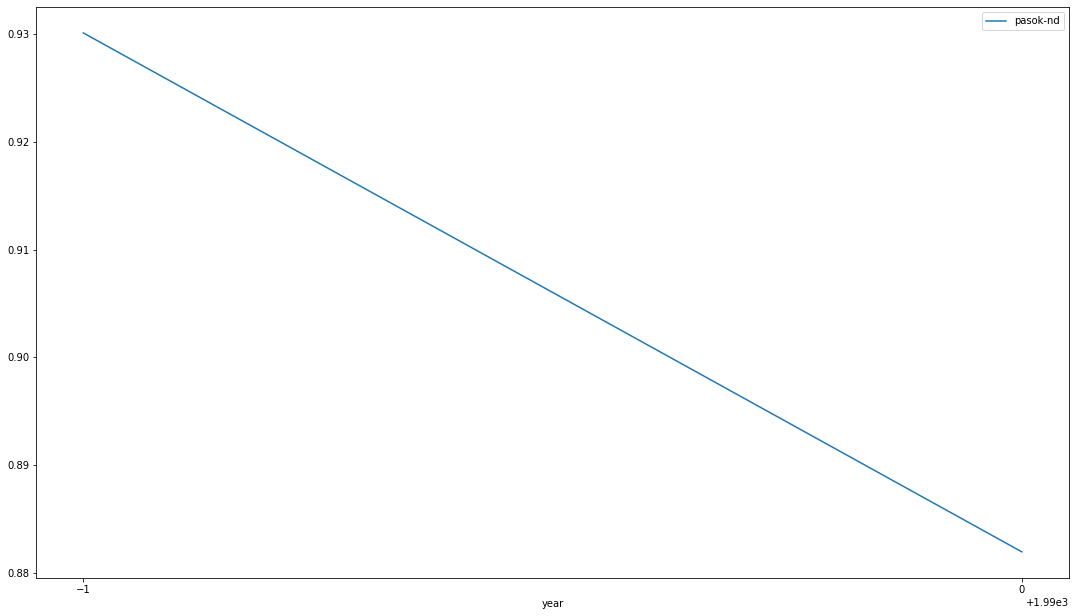

In [42]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

for_plot.plot(x_compat=True,ax=ax)

ax.locator_params(integer=True)
#ax.xaxis.set_tick_params(reset=True)

plt.show()